# Schematic Driven layout

The Schematic driven layout uses a schematic format similar to our `*.pic.yml`.

The Jupyter notebook interface allows you to get the best of both worlds of GUI and python driven based flows.

In [1]:
%env BOKEH_ALLOW_WS_ORIGIN=localhost:8888

from gdsfactory.schematic_editor import SchematicEditor
from bokeh.io import output_notebook
import os
import gdsfactory as gf

output_notebook()

env: BOKEH_ALLOW_WS_ORIGIN=localhost:8888


2023-01-03 02:09:53.206 | INFO     | gdsfactory.config:<module>:48 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.17.0


Loading BokehJS ...

First you initialize a session of the schematic editor.
The editor is synced to a file.
If file exist, it loads the schematic for editing. If it does not exist, it creates it.
The schematic file is continuously auto-saved as you edit the schematic in your notebook, so you can track changes with GIT.

In [2]:
se = SchematicEditor("test.schem.yml")

## Define instances

First you need to define which instances to include. We do this through this grid-like editor.
Components are auto-populated from your active PDK.

instance name | Component type
--------------| --------------
mmi1          | mmi1x2


In [3]:
se.instance_widget

In [4]:
se.instances.keys()

dict_keys(['mmi1', 'mmi2', 's1', 's2'])

You can also **add your instances through code**, and since it is just a dictionary update, *the integrity of your schematic will be maintained, even after re-running the notebook* as-is.
You can here specify a component either by name or as an actual component, using auto-completion to specify your settings as well.

In [5]:
se.add_instance("s1", gf.components.straight(length=20))
se.add_instance("s2", gf.components.straight(length=40))

But you can even query the parameters of default components, set only by name through the widget grid, like so:

In [6]:
se.instances["mmi1"].settings.full

{'width': None,
 'width_taper': 1.0,
 'length_taper': 10.0,
 'length_mmi': 5.5,
 'width_mmi': 2.5,
 'gap_mmi': 1.0,
 'taper': {'function': 'taper'},
 'with_bbox': True,
 'cross_section': 'strip'}

It is also possible to *instantiate through the widget, then set the settings of our component later, through code.*

By doing this through code, we have the full power of python at our disposal to easily use shared variables between components, or set complex Class or dictionary-based settings, without fumbling through a UI.

In [7]:
se.update_settings("mmi1", gap_mmi=1.0)
se.update_settings("mmi2", gap_mmi=0.7)

for inst_name, inst in se.instances.items():
    if inst.settings.changed:
        print(f"{inst_name}: {inst.settings.changed}")

mmi1: {'gap_mmi': 1.0}
mmi2: {'gap_mmi': 0.7}
s1: {'length': 20}
s2: {'length': 40}


## Define nets

Now, you define your logical connections between instances in your netlist. Each row in the grid represents one logical connection.

In [8]:
se.net_widget

Similarly, you can programmatically add nets.
Adding a net which already exists will have no effect, such that the notebook can be rerun without consequence.
However, trying to connect to a port which is already otherwise connected will throw an error.

In [9]:
se.add_net(
    inst1="mmi1", port1="o2", inst2="s1", port2="o1"
)  # can be re-run without consequence
se.add_net(inst1="s1", port1="o1", inst2="mmi1", port2="o2")  # also ok
# se.add_net(inst1="s1", port1="o2", inst2="mmi1", port2="o2")  # throws error -- already connected to a different port

## Visualize

You can visualize your schematic down below. After you've initialized the plot below, you should see it live-update after every change we make above.

Currently the *size of component symbols and location of ports are **layout-realistic***. This may be a nice default if you don't care to bother making symbols for your components.
But it would be a nice improvement for the future to allow associating symbols with components, to make the schematic easier to read.

If you activate the `Point Draw Tool` in the plot, you should see that you are able to arrange components freely on the schematic, and changes are saved back to the `*.schem.yml` file in realtime.

In [10]:
se.visualize()

## generate Layout

You can use your schematic to generate a preliminary layout, and view in the notebook and/or KLayout. Initial placements come from schematic placements and Routes are auto-generated from nets.

/home/runner/work/gdsfactory/gdsfactory/gdsfactory/component.py:1480: UserWarning: Component 'Unnamed_5ecca3de' contains 1 Unnamed cells
  warnings.warn(


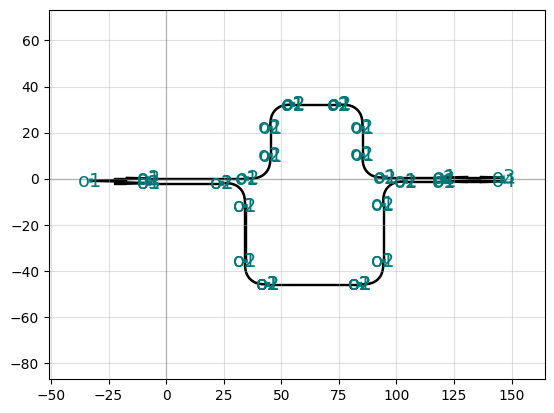

Unnamed_5ecca3de: uid e4ac5717, ports [], references ['mmi1', 'mmi2', 's1', 's2', 'bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_3', 'bend_euler_4', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_5', 'bend_euler_6', 'straight_7', 'straight_8', 'straight_9', 'bend_euler_7', 'bend_euler_8', 'straight_10', 'straight_11', 'straight_12'], 0 polygons

In [11]:
layout_filename = "sdl_demo.pic.yml"
se.instantiate_layout(layout_filename, default_router="get_bundle")
c = gf.read.from_yaml(layout_filename)
c.show()
c

## TODO
- [ ] Demonstrate using visualizer to interactively refine layout placements, live
- [x] Implement symbols for components in schematic view
- [ ] Prettier display of nets and better control over waypoints
- [x] Allow rotation/mirroring in schematic placements

In [12]:
# you can save your schematic to a standalone html file once you are satisfied
# se.save_schematic_html('demo_schem.html')